# Importação das bibliotecas necessárias

In [1]:
# import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from unidecode import unidecode

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
from skopt import BayesSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import lime
import lime.lime_tabular

# Criação de dataset

In [2]:
df = pd.read_feather('../data/carteira_total.feather')


In [3]:
df.head(3)

mÊs    ID CRM  ID NAVPLAT      ID SAP REGIÃO      CIDADE      BAIRRO  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   VALOR MENSAL  VALOR HOJE UPSALE/DOWNSALE  ...  LEADS FORM LEADS VER DATO  \
0         434.4       434.4              ok  ...        21.0          100.0   
1         312.0       312.0              ok  ...        18.0          106.0   
2        1798.8      1798.8              ok  ...       174.0          520.0   

  LEADS TOTAL Custo por lead total  Total Contratado  TOTAL DE LISTINGS  \
0       121.0             3.590083              50.0                  9   
1       124.0             2.516129              25.0                  7   
2       694.0             2.591931           10031.0                 67   

   CUSTO POR LISTING  PF/PJ  Total Utilizado  Faixa Listings  
0          48.266667     PJ              9.0          6 – 10  
1          44.571429     PF              7.0          6 – 10  
2          26.847761     PJ             67.0        61 – 100  

[3 rows x 36 columns]

# Pandas Proffling

In [4]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

In [5]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica


# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [6]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [7]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)
df['churn'] = df['churn'].astype(int)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [8]:
df.head(3)

mes    id_crm  id_navplat      id_sap regiao      cidade      bairro  \
0 2020-01-01  10400005    10400005  2000340391     DF  SOBRADINHO  Sobradinho   
1 2020-01-01  10400007    10400007  2000340644     DF    BRASÍLIA     Asa Sul   
2 2020-01-01  10400014    10400014  2000254856     DF    BRASÍLIA     Asa Sul   

   valor_mensal  valor_hoje  faturamento  ... leads_ver_dato leads_total  \
0         434.4       434.4        434.0  ...          100.0       121.0   
1         312.0       312.0        312.0  ...          106.0       124.0   
2        1798.8      1798.8       1799.0  ...          520.0       694.0   

  custo_por_lead_total  total_contratado  total_de_listings  \
0             3.590083              50.0                  9   
1             2.516129              25.0                  7   
2             2.591931           10031.0                 67   

   custo_por_listing  pf_pj  total_utilizado  faixa_listings  churn  
0          48.266667     PJ              9.0          6 – 10      0  
1          44.571429     PF              7.0          6 – 10      0  
2          26.847761     PJ             67.0        61 – 100      0  

[3 rows x 36 columns]

In [9]:
df_grouped = df[['mes', 'id_sap']].groupby(['id_sap']).count().reset_index()

df_grouped.rename(columns = {'mes':'quantidade_mes'}, inplace=True)

In [10]:
df_grouped.sample(2)


In [11]:
df = df.join(df_grouped.set_index('id_sap'), on='id_sap')
    

In [12]:
df.sample(2)

#### Definição do quality score de cada registro (NÃO FINALIZADO E NÃO UTILIZADO)

In [13]:
# xls = pd.ExcelFile('../data/quality_score.xlsx')
# xls.sheet_names

# i = 0
# for data in xls.sheet_names:
#     if i == 0:
#         dfQuality = pd.read_excel(xls, data)
#         dfQuality['data'] = data
#         dfQuality.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
#                                   'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)
#     else:
#         dfQualityAux = pd.read_excel(xls, data)
#         dfQualityAux['data'] = data
#         dfQualityAux.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
#                                      'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)

#         dfQuality = pd.concat([dfQuality, dfQualityAux])

#     i+=1

In [14]:
# dfQuality['status_pagamento'].unique()


In [15]:
# dfQuality['status_pagamento'].replace({'4. Péssimo': 'Pessimo', '2. Regular ': 'Regular', '1. Bom': 'Bom', '3. Ruim': 'Ruim', '5. Novo': 'Novo',
#                                        '2. Regular': 'Regular', '1. Bom ': 'Bom', 'lançamentos': np.nan, '5. novo': 'Novo', 0: np.nan}, inplace=True)


In [16]:
# df_grouped = dfQuality[['ID SAP', 'status_pagamento']].groupby(['ID SAP']).agg(pd.Series.mode).reset_index()
# df_grouped.rename(columns={"status_pagamento": "status_pagamento_mode"}, inplace=True)


In [17]:
# df_grouped.head(2)

In [18]:
# dfQuality = dfQuality.join(df_grouped.set_index('ID SAP'), on='ID SAP')


In [19]:
# dfQuality.head(50)


In [20]:
# dfQuality['status_pagamento'] = dfQuality['status_pagamento'].fillna(dfQuality['status_pagamento_mode']).copy()


In [21]:

# dfQuality.isna().sum()

In [22]:
# dfQuality.drop(columns='status_pagamento_mode', inplace=True)

In [23]:
# df[~df['id_sap'].isin(dfQuality['ID SAP'].unique())][df['churn'] == 1]


In [24]:
# dfQuality['ID SAP'].unique()

In [25]:
# regex = r'([0-9]{4})-([0-9]{2})-[0-9]{2}'

# def fun_replace(data): 
#     return datetime.datetime.strptime(str(data.group(2)).lower(), '%m').strftime('%b').lower() + data.group(1)[-2:]

# df['mes'] = df['mes'].astype(str).str.replace(regex, fun_replace, regex=True)


## Padronizando valores categóricos

### Oficina

In [26]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [27]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

### Faturamento

In [28]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', '0'], dtype=object)

In [29]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [30]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

In [31]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', '0'], dtype=object)

### Tipo de Plano

In [32]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', 'nan', 'SIMPLES', 'PACK', '0'],
      dtype=object)

### Midia Ativa

In [33]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', None], dtype=object)

### PF_PJ

In [34]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

### Equipe

In [35]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [36]:
# Alterando para valores ficarem iguais
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)
df['equipe'].unique()

array(['REGIONAL DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias'],
      dtype=object)

In [37]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [38]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Analise Grafica

### Análise região (não aparenta influenciar no churn)

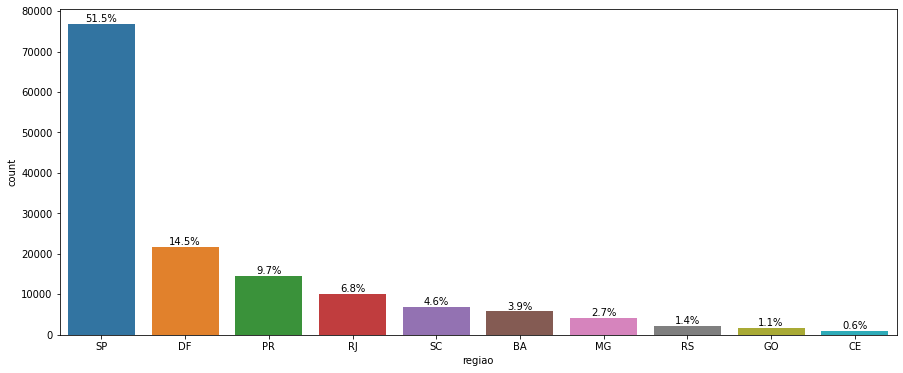

In [39]:
serie_filtrada = df["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

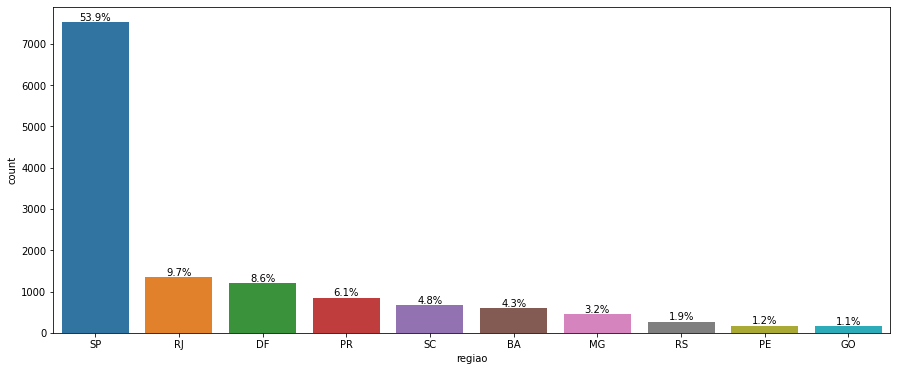

In [40]:
serie_filtrada = df[df["churn"] == 1]["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Cidade (não aparenta influenciar no churn)

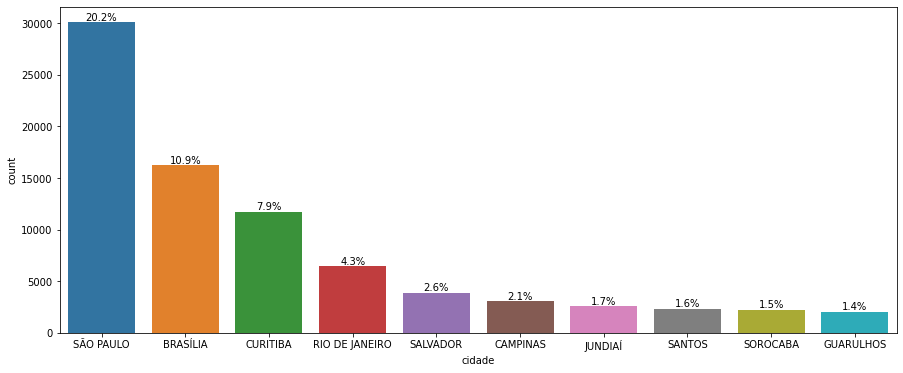

In [41]:
serie_filtrada = df["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

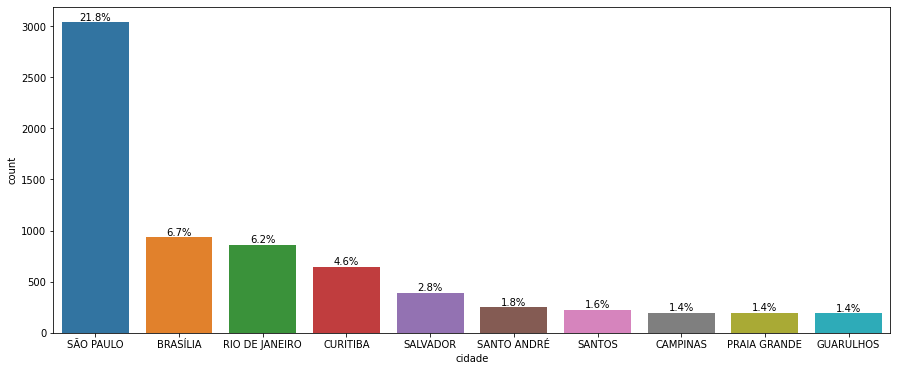

In [42]:
serie_filtrada = df[df["churn"] == 1]["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Oficina (não aparenta influenciar no churn)

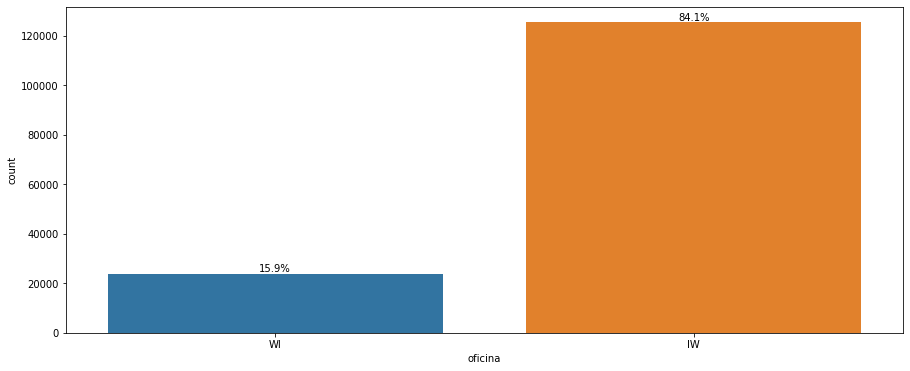

In [43]:
serie_filtrada = df["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

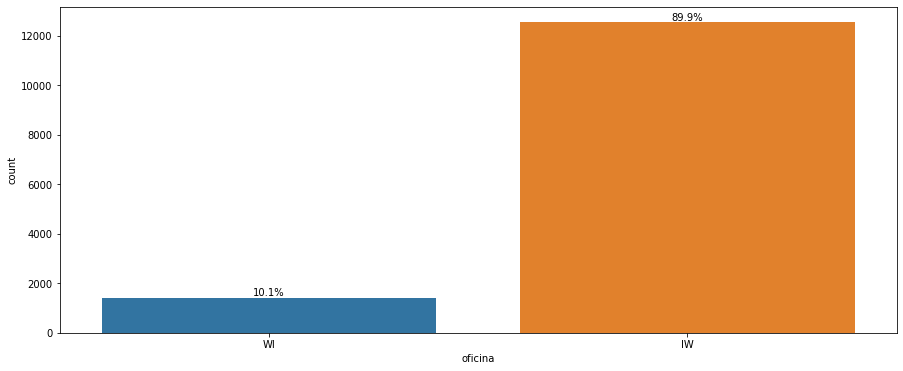

In [44]:
serie_filtrada = df[df["churn"] == 1]["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Frequência Faturamento (não aparenta influenciar no churn)

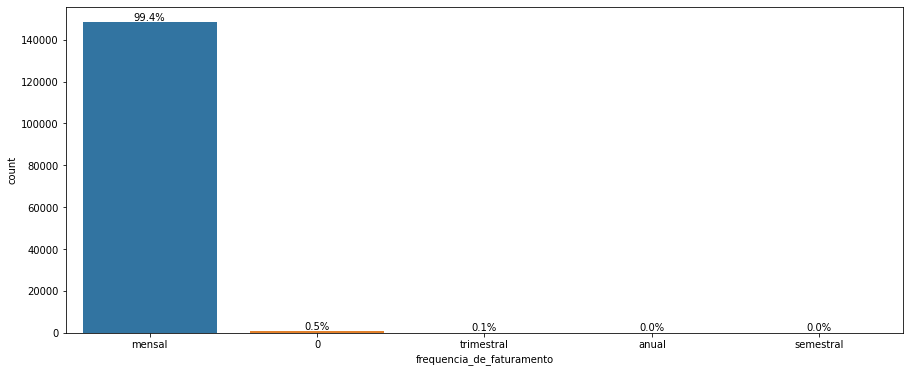

In [45]:
serie_filtrada = df["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

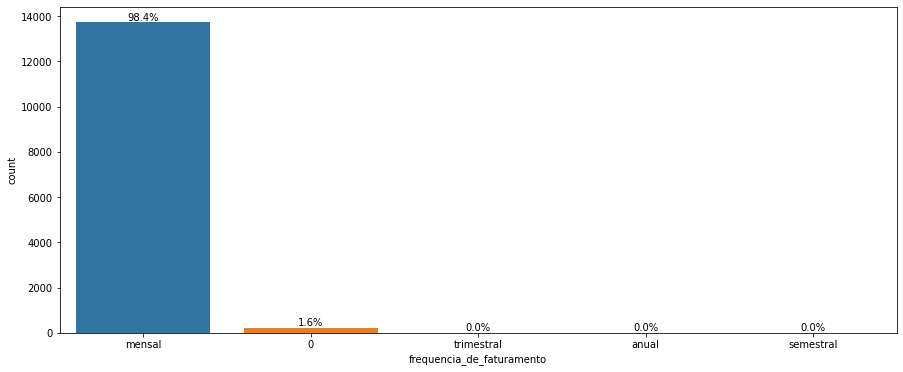

In [46]:
serie_filtrada = df[df["churn"] == 1]["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Tipo de Plano (pode influenciar no churn)

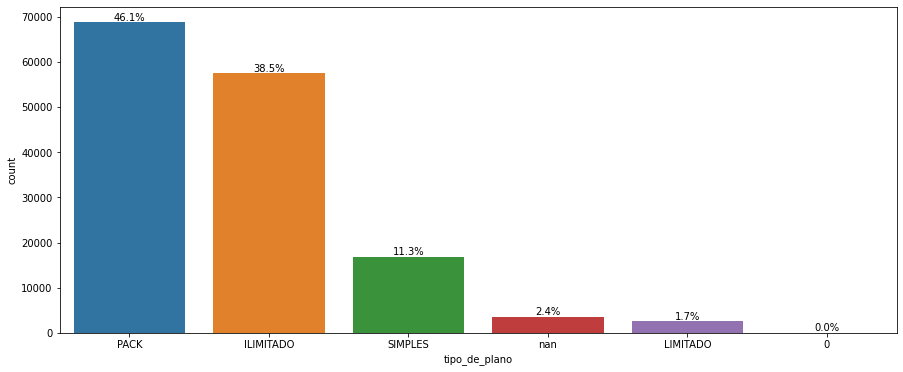

In [47]:
serie_filtrada = df["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

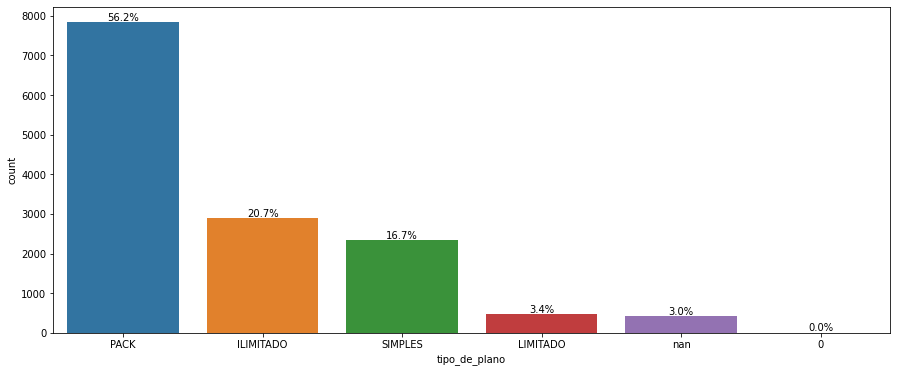

In [48]:
serie_filtrada = df[df["churn"] == 1]["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Executivo Carteira Atual (não aparenta influenciar no churn)

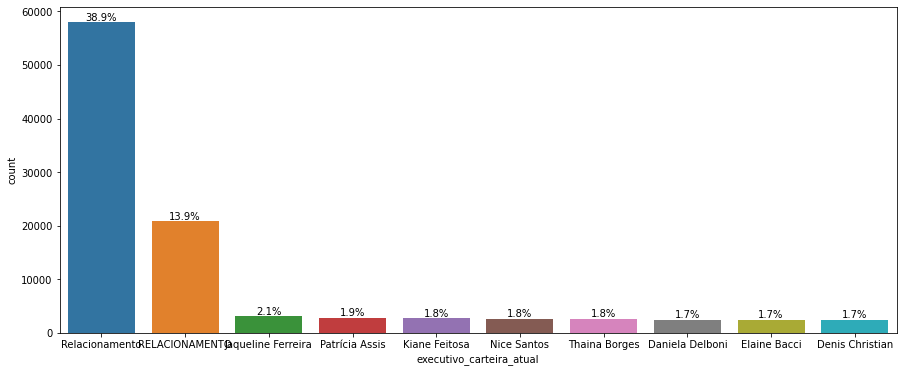

In [49]:
serie_filtrada = df["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

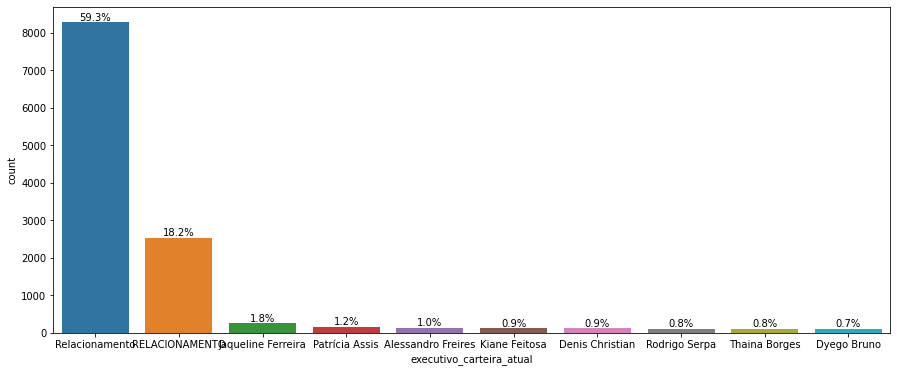

In [50]:
serie_filtrada = df[df["churn"] == 1]["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Equipe (pode influenciar no churn)

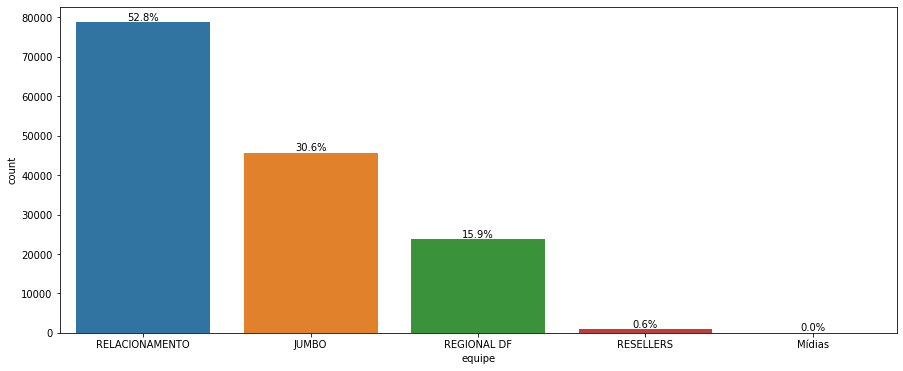

In [51]:
serie_filtrada = df["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

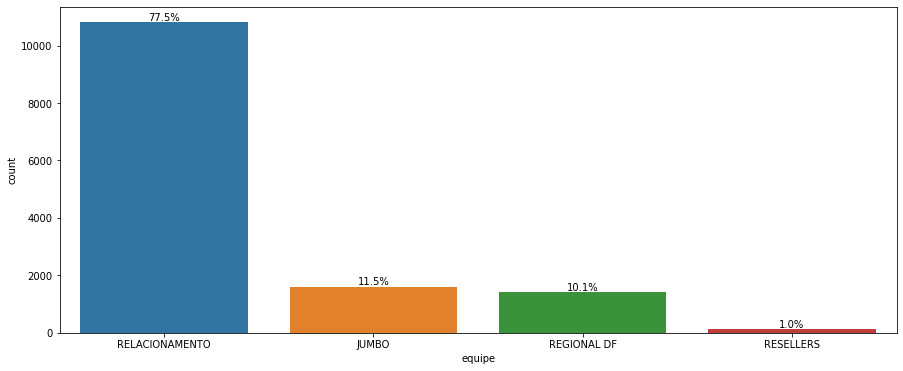

In [52]:
serie_filtrada = df[df["churn"] == 1]["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Status Final (alta correlação com churn, talvez não seja interessante manter)

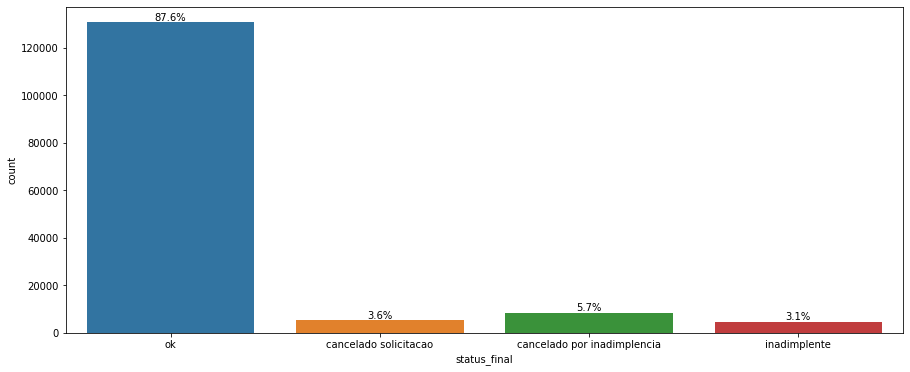

In [53]:
serie_filtrada = df["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

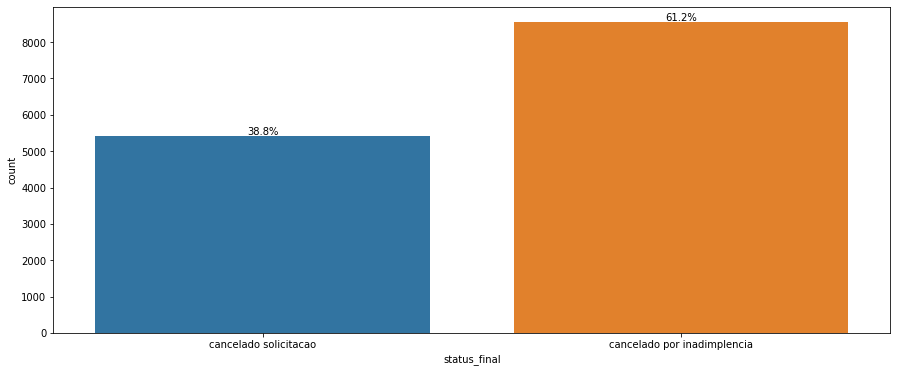

In [54]:
serie_filtrada = df[df["churn"] == 1]["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Possui Midia Ativa (pode ter influencia no churn, mas muito pouco)

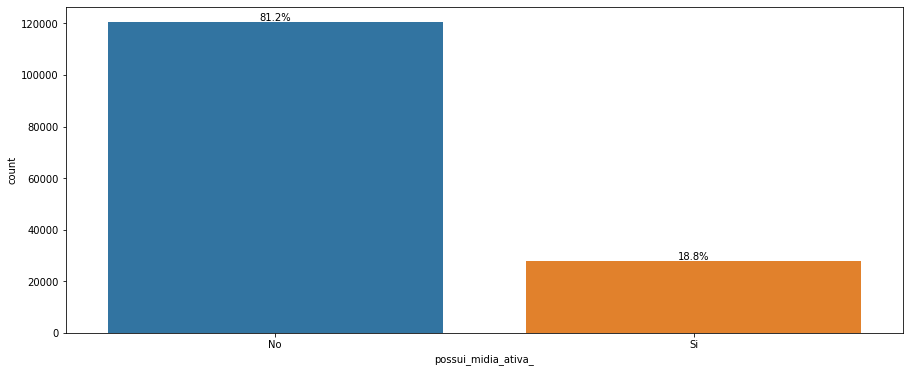

In [55]:
serie_filtrada = df["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

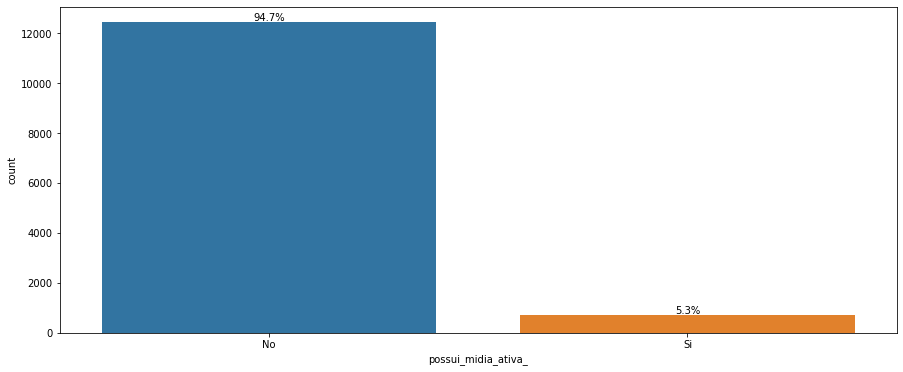

In [56]:
serie_filtrada = df[df["churn"] == 1]["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Pessoa Física Jurídica (relação forte com o churn)

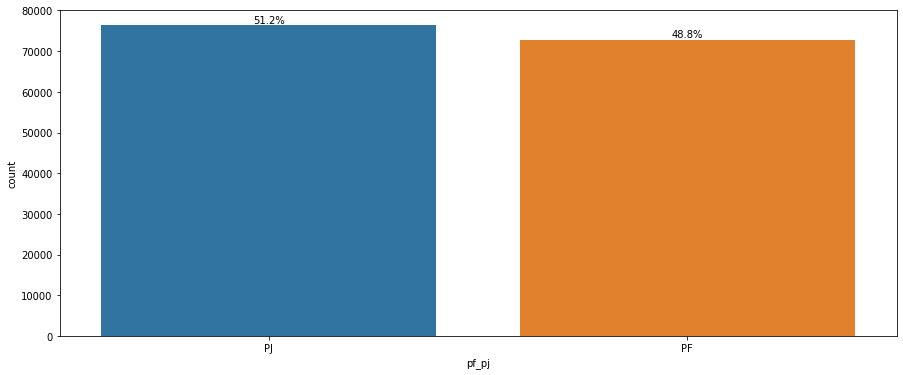

In [57]:
serie_filtrada = df["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

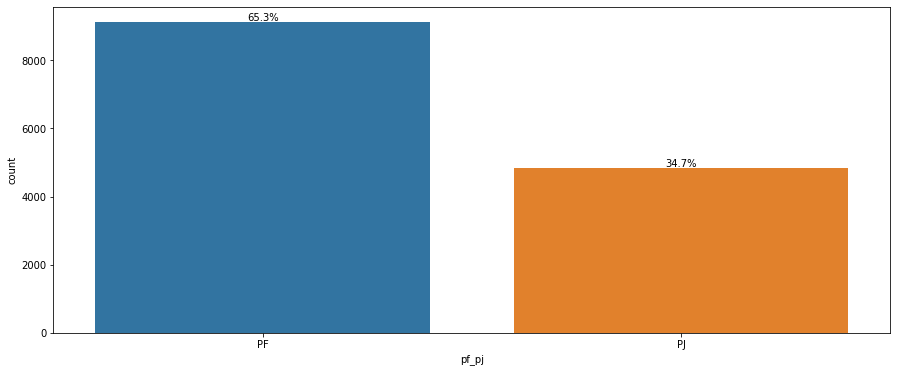

In [58]:
serie_filtrada = df[df["churn"] == 1]["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Faixa Listings (relação forte com o churn)

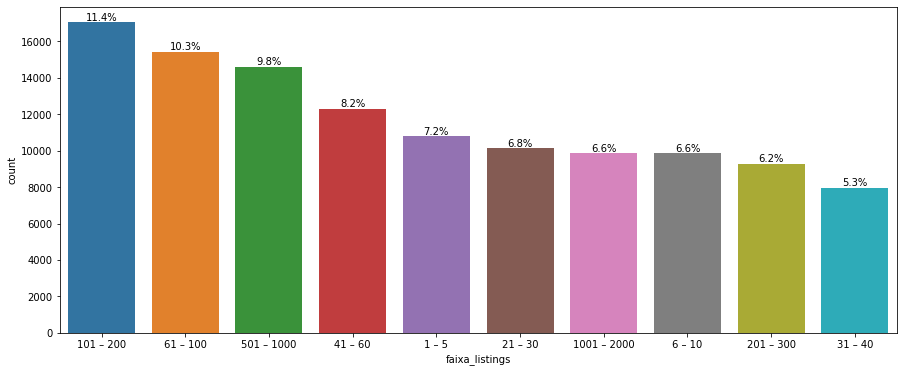

In [59]:
serie_filtrada = df["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

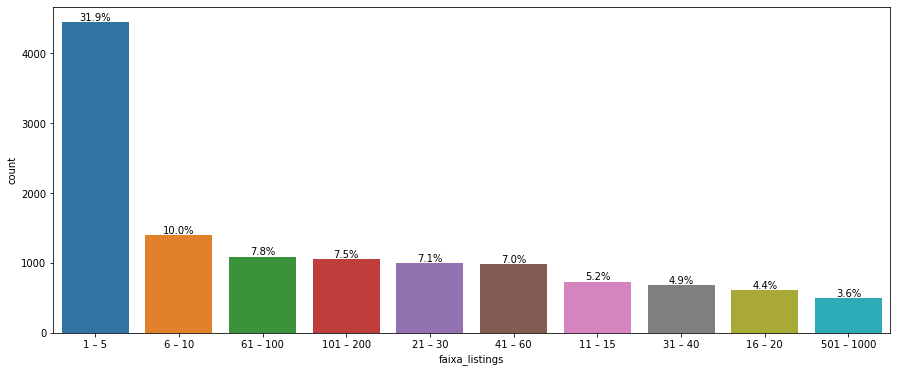

In [60]:
serie_filtrada = df[df["churn"] == 1]["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

Template

### Análise Valor Mensal (pode influenciar no churn, mas pouco)

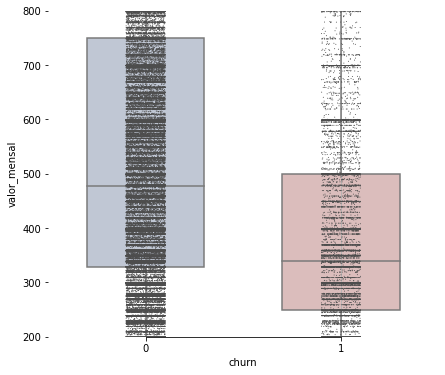

In [61]:
coluna_medida = "valor_mensal"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Valor Hoje (alta correlação com churn. Talvez seja melhor remover)

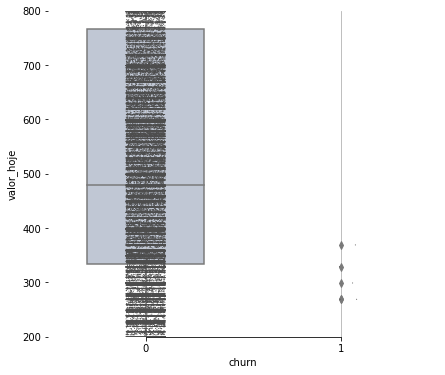

In [62]:
coluna_medida = "valor_hoje"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Faturamento (Alta correlação com churn. Talvez seja melhor tirar)

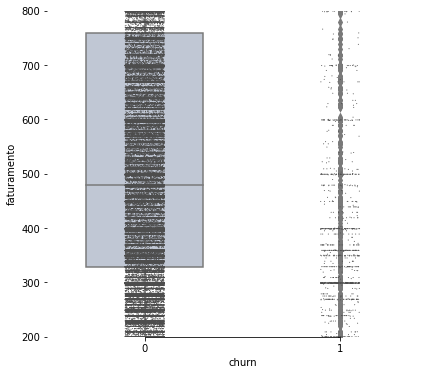

In [63]:
coluna_medida = "faturamento"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Super Destaques (pode influenciar no churn)

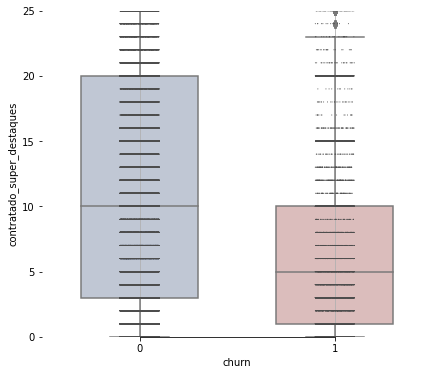

In [64]:
coluna_medida = "contratado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Contratado Destaques (não aparenta influenciar no churn)

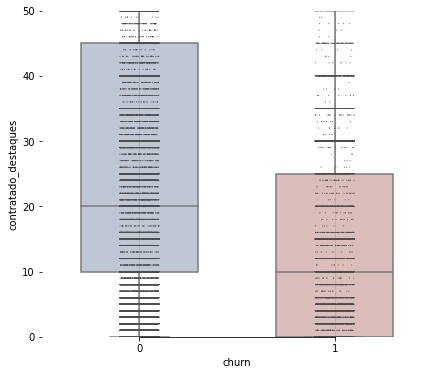

In [65]:
coluna_medida = "contratado_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Ofertas Simples (Relação forte com o churn)

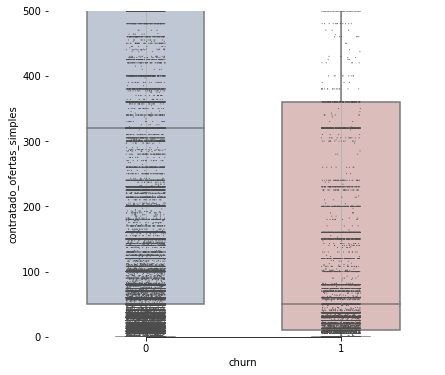

In [66]:
coluna_medida = "contratado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Super Destaque (pode influenciar o churn)

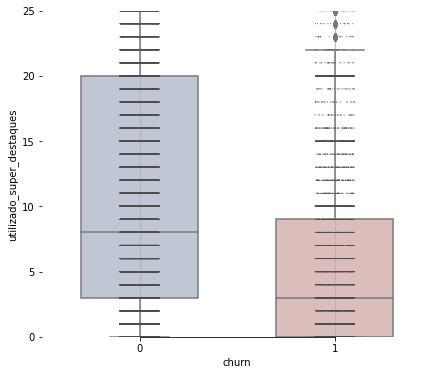

In [67]:
coluna_medida = "utilizado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Utilizado Destaque (pode influenciar o churn)

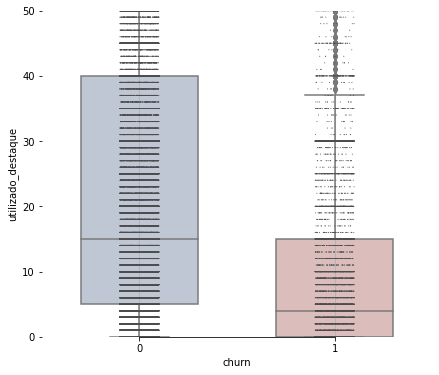

In [68]:
coluna_medida = "utilizado_destaque"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Ofertas Simples (Relação forte com o churn)

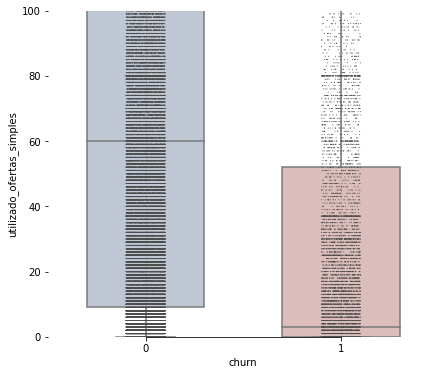

In [69]:
coluna_medida = "utilizado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Form (Relação forte com o churn)

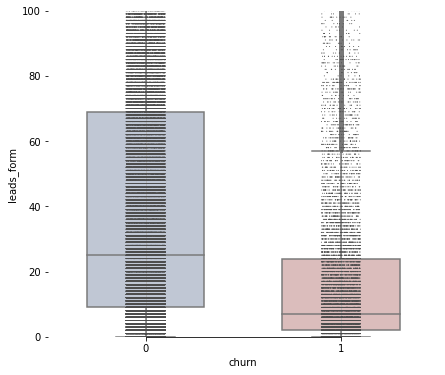

In [70]:
coluna_medida = "leads_form"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Ver Dato (Relação forte com o churn)

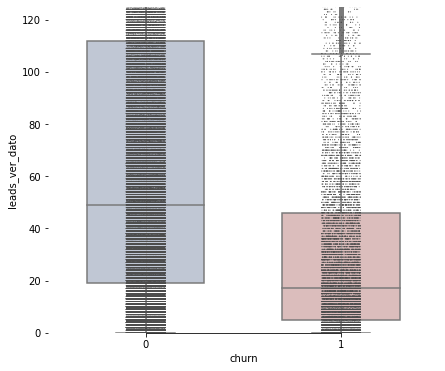

In [71]:
coluna_medida = "leads_ver_dato"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 125))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Total (Relação forte com o churn)

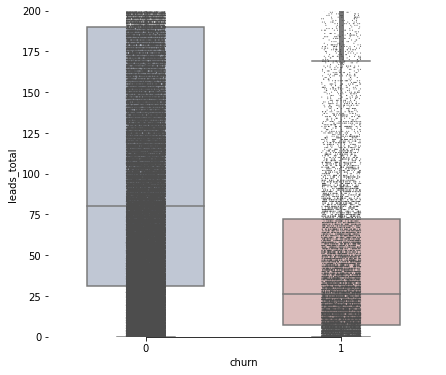

In [72]:
coluna_medida = "leads_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 200))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Custo Por Lead Total (Alta correlação com churn. Talvez seja melhor remover)

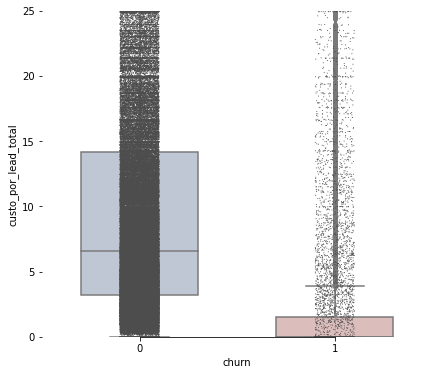

In [73]:
coluna_medida = "custo_por_lead_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Contratado (Relação fortíssima com o churn)

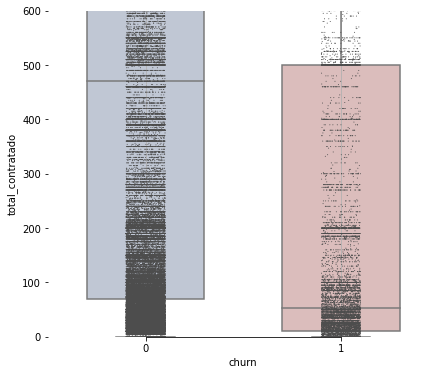

In [74]:
coluna_medida = "total_contratado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 600))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Total de Listings (Relação forte com o churn)

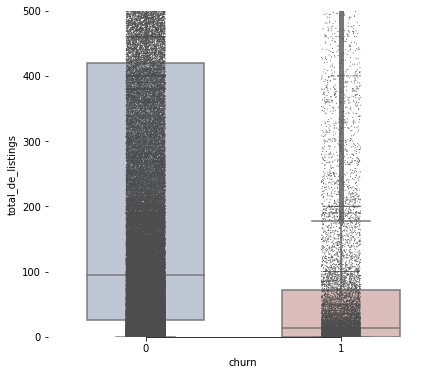

In [75]:
coluna_medida = "total_de_listings"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Custo Por Listing (Alta correlação com churn. Talvez seja melhor remover)

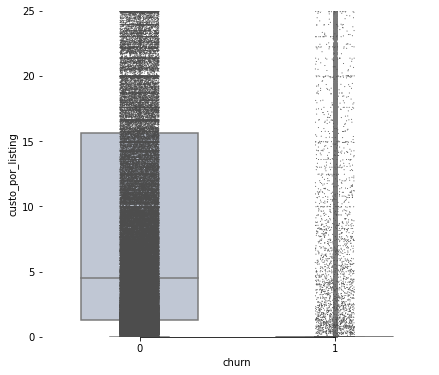

In [76]:
coluna_medida = "custo_por_listing"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Utilizado (Relação fortíssima com o churn)

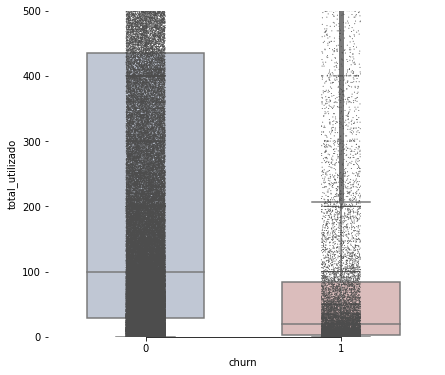

In [77]:
coluna_medida = "total_utilizado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Quantidade Mês (Relação fortíssima com o churn)

ValueError: Could not interpret input 'quantidade_mes'

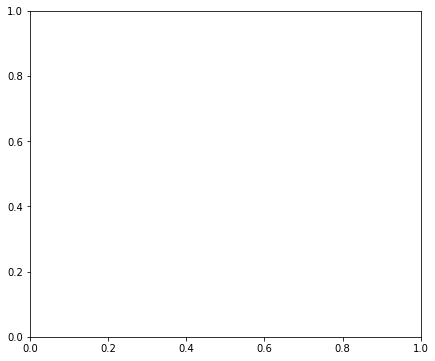

In [80]:
coluna_medida = "quantidade_mes"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 30))
sns.stripplot(x="churn", y=coluna_medida, data=df,
              size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)


# Data Cleaning and Data Wrangling

### Criação de novo dataframe com somente as colunas relevantes

In [ ]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [ ]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings',
         'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques',
         'utilizado_destaque', 'valor_mensal', 'quantidade_mes', 'churn']].copy()


### Plot do gráfico de correlação entre variáveis preditoras

In [ ]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

# Modeling

### Isolar a variável de churn (target)

In [ ]:
dfChurn = df['churn']

### Tratamento das variáveis categóricas

#### Dumificação

In [ ]:
df.select_dtypes(include=['object'])


pf_pj       equipe
0         PJ  REGIONAL DF
1         PF  REGIONAL DF
2         PJ  REGIONAL DF
3         PJ  REGIONAL DF
4         PJ  REGIONAL DF
...      ...          ...
149183    PJ  REGIONAL DF
149184    PJ  REGIONAL DF
149185    PF  REGIONAL DF
149186    PF  REGIONAL DF
149187    PF  REGIONAL DF

[149188 rows x 2 columns]

In [ ]:
dfCategorical = pd.get_dummies(df.select_dtypes(include=['object']), columns=['pf_pj', 'equipe'])


In [ ]:
dfCategorical.head()

pf_pj_PF  pf_pj_PJ  equipe_JUMBO  equipe_Mídias  equipe_REGIONAL DF  \
0         0         1             0              0                   1   
1         1         0             0              0                   1   
2         0         1             0              0                   1   
3         0         1             0              0                   1   
4         0         1             0              0                   1   

   equipe_RELACIONAMENTO  equipe_RESELLERS  
0                      0                 0  
1                      0                 0  
2                      0                 0  
3                      0                 0  
4                      0                 0

### Tratamento das variáveis numéricas

In [ ]:
dfNumerical = df.select_dtypes(include=np.number).drop(['churn'], axis=1)


#### Tratamento de nulos (substituição por medianas)

In [ ]:
dfNumerical.isna().sum()


contratado_ofertas_simples      0
utilizado_ofertas_simples       2
leads_form                     32
leads_ver_dato                 34
total_contratado              535
total_de_listings               0
total_utilizado                 2
contratado_super_destaques      0
utilizado_super_destaques       2
utilizado_destaque              2
quantidade_mes                  0
dtype: int64

In [ ]:
dfNumerical = dfNumerical.fillna(dfNumerical.median())


In [ ]:
dfNumerical.isna().sum()


contratado_ofertas_simples    0
utilizado_ofertas_simples     0
leads_form                    0
leads_ver_dato                0
total_contratado              0
total_de_listings             0
total_utilizado               0
contratado_super_destaques    0
utilizado_super_destaques     0
utilizado_destaque            0
quantidade_mes                0
dtype: int64

#### Transformação de valores negativos para 0

In [ ]:
for col in dfNumerical.columns:
    df[col][dfNumerical[col] < 0] = 0

### Tratamento de outliers e normalização dos dados

In [79]:
dfNumerical = dfNumerical.copy()
dfNumerical[['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings', 'total_utilizado', 'contratado_super_destaques', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal']] = RobustScaler().fit_transform(dfNumerical[['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'leads_ver_dato',
                                                                                       'total_contratado', 'total_de_listings', 'total_utilizado', 'contratado_super_destaques', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal']])


NameError: name 'dfNumerical' is not defined

### Concatenação das variáveis tratadas à variável target

In [ ]:
df = pd.concat([dfNumerical, dfCategorical, dfChurn], axis = 1, join='inner')

In [ ]:
df.head()


contratado_ofertas_simples  utilizado_ofertas_simples  leads_form  \
0                   -0.021078                  -0.135048   -0.035088   
1                   -0.023587                  -0.141479   -0.087719   
2                    0.977617                  -0.048232    2.649123   
3                    0.977617                   0.106109    1.807018   
4                   -0.006022                  -0.064309   -0.052632   

   leads_ver_dato  total_contratado  total_de_listings  total_utilizado  \
0        0.617978         -0.033106          -0.203343        -0.213904   
1        0.685393         -0.035614          -0.208914        -0.219251   
2        5.337079          0.968198          -0.041783        -0.058824   
3        2.921348          0.971108           0.172702         0.147059   
4        0.764045         -0.018058          -0.142061        -0.155080   

   contratado_super_destaques  utilizado_super_destaques  utilizado_destaque  \
0                   -0.529412                  -0.466667           -0.483871   
1                   -0.529412                  -0.466667           -0.483871   
2                   -0.470588                  -0.400000            0.483871   
3                    1.235294                   1.533333            0.483871   
4                   -0.529412                  -0.466667           -0.483871   

   quantidade_mes  pf_pj_PF  pf_pj_PJ  equipe_JUMBO  equipe_Mídias  \
0              22         0         1             0              0   
1              22         1         0             0              0   
2              22         0         1             0              0   
3               8         0         1             0              0   
4              22         0         1             0              0   

   equipe_REGIONAL DF  equipe_RELACIONAMENTO  equipe_RESELLERS  churn  
0                   1                      0                 0      0  
1                   1                      0                 0      0  
2                   1                      0                 0      0  
3                   1                      0                 0      0  
4                   1                      0                 0      0

### Testes com algorítmos executados manualmente

#### Divisão do dataset em treino e teste e validação

In [ ]:
X = df.drop(['churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns = X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#### Execução do modelo

In [ ]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'num_class': 3}

steps = 20  # The number of training iterations

modelXG = xgb.train(param, D_train, steps)

modelRF = RandomForestClassifier(n_jobs=-1)
modelRF.fit(X_train, y_train)

modelGB = GradientBoostingClassifier()
modelGB.fit(X_train, y_train)


GradientBoostingClassifier()

#### Resultados do modelo

In [ ]:
predictXG = modelXG.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in predictXG])

f1 = round(f1_score(y_test, best_preds, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, best_preds)*100, 2)
precision = round(precision_score(y_test, best_preds)*100, 2)
recall = round(recall_score(y_test, best_preds)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


F1 Score: 76.81%
Accuracy Score: 93.87%
Precision Score: 84.42%
Recall Score: 42.93%


F1 Score: 78.89%
Accuracy Score: 93.9%
Precision Score: 76.62%
Recall Score: 50.78%


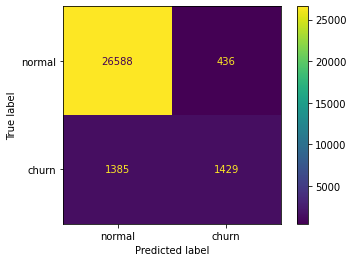

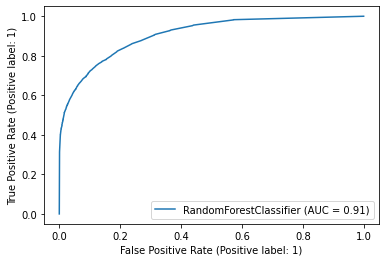

In [ ]:
predictRF = modelRF.predict(X_test)

f1 = round(f1_score(y_test, predictRF, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictRF)*100, 2)
precision = round(precision_score(y_test, predictRF)*100, 2)
recall = round(recall_score(y_test, predictRF)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_test, y_test)
plt.show()


F1 Score: 78.91%
Accuracy Score: 94.33%
Precision Score: 87.26%
Recall Score: 46.73%


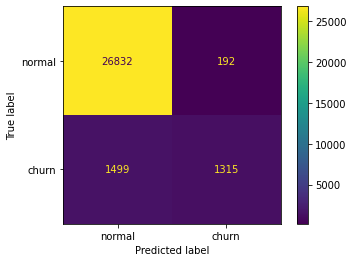

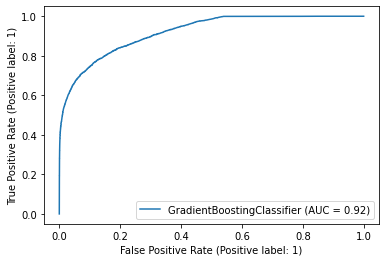

In [ ]:
predictGB = modelGB.predict(X_test)

f1 = round(f1_score(y_test, predictGB, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictGB)*100, 2)
precision = round(precision_score(y_test, predictGB)*100, 2)
recall = round(recall_score(y_test, predictGB)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_test, y_test)
plt.show()


In [ ]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


accuracy  precision  recall     f1
XGBoost              93.87      84.42   42.93  76.81
RandomForest         93.90      76.62   50.78  78.89
GradientBoosting     94.33      87.26   46.73  78.91

### Tunning de hiperparâmetros dos melhores modelos

In [ ]:
parameters = {
    'learning_rate': [0.01, 0.02, 0.03],
    'subsample': [0.9, 0.5, 0.2],
    'n_estimators': [100, 500, 1000],
    'max_depth': [4, 6, 8]
}

bayes_search = BayesSearchCV(modelGB, search_spaces=parameters, cv=3, n_jobs=-1, verbose=2)
bayes_search.fit(X_train, y_train)


In [ ]:
bayes_search.best_estimator_
Results: GradientBoostingClassifier(max_depth=7, n_estimators=50)


F1 Score: 80.29%
Accuracy Score: 94.65%
Precision Score: 89.08%
Recall Score: 49.29%


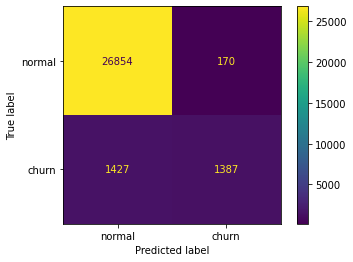

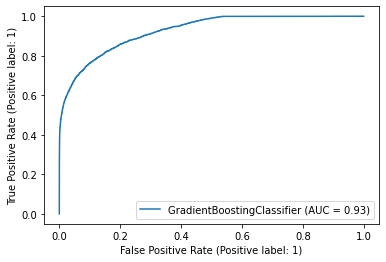

In [204]:
modelGB = GradientBoostingClassifier(max_depth=7, n_estimators=50)
modelGB.fit(X_train, y_train)

y_pred = modelGB.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")
                      
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_test, y_test)
plt.show()


In [205]:
# parametros = {
#     'max_depth': [100, 150],
#     'max_features': [3, 4, 5],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [2, 3, 8, 10],
#     'n_estimators': [200, 300, 400]
# }

# bayes_search = BayesSearchCV(estimator=modelRF, search_spaces=parametros, n_jobs=-1, cv=3, verbose=2)
# bayes_search.fit(X_train, y_train)


In [206]:
# bayes_search.best_estimator_
# Results: RandomForestClassifier(criterion='entropy', max_depth=150, max_features=5, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 300)


F1 Score: 79.72%
Accuracy Score: 94.45%
Precision Score: 86.22%
Recall Score: 48.93%


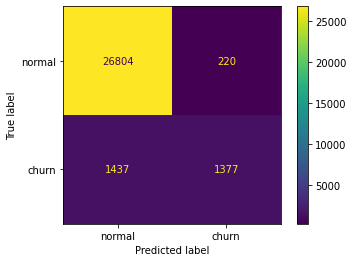

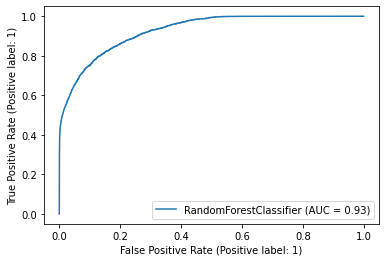

In [207]:
modelRF = RandomForestClassifier(criterion='entropy', max_depth=150, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=300)
modelRF.fit(X_train, y_train)

y_pred = modelRF.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_test, y_test, display_labels=[
                      "normal", "churn"], values_format="d")

plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_test, y_test)
plt.show()


### Definição do melhor modelo

In [208]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


accuracy  precision  recall     f1
GradientBoosting     94.65      89.08   49.29  80.29
RandomForest         94.45      86.22   48.93  79.72

In [209]:
clf = modelGB

### Avaliação da performance do modelo com os dados de validação

In [210]:
y_pred = clf.predict(X_val)

data_set_valid = X_val.reset_index(drop=True)
y_real = pd.Series(y_val).reset_index(drop=True)
y_predito = pd.Series(y_pred, name='churn_predito').reset_index(drop=True)

df_valid = pd.concat([data_set_valid, y_real, y_predito], axis=1)

Quantidade total: 29838
Preditos Corretamente: 28229
Preditos Icorretamente: 1609


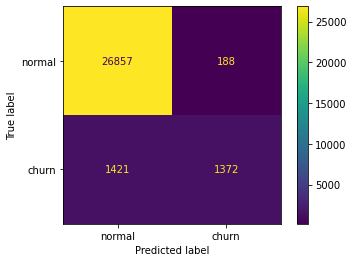

In [211]:
print('Quantidade total: {}'.format(len(df_valid)))
print('Preditos Corretamente: {}'.format(len(df_valid[df_valid['churn'] == df_valid['churn_predito']])))
print('Preditos Icorretamente: {}'.format(len(df_valid[df_valid['churn'] != df_valid['churn_predito']])))


plot_confusion_matrix(clf, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")


### Interpretabilidade individual do resultado dos registros classificados pelo modelo

In [212]:
def predict_explainer(df_fil):
    ''' Apresenta o explain das probabilidades que definiram o registro como "churn" ou não '''
    index_registro_visualizacao = df_fil.sample().index[0]

    print('Quantidade de registros preditos nessa categoria: {}'.format(len(df_fil)))
    print()
    print('-' * 5 + ' Churn Real / Churn Predito ' + '-' * 5)
    print()
    print(df_valid[['churn', 'churn_predito']
                   ].iloc[index_registro_visualizacao])
    print()
    print('-' * 5 + ' Probabilidade ' + '-' * 5)

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=[
                                                       "Não Churn", "Churn"],
                                                   mode='classification')

    exp = explainer.explain_instance(X_val.iloc[index_registro_visualizacao],
                                     clf.predict_proba,
                                     num_features=10,
                                     top_labels=1)

    return exp.show_in_notebook(show_table=True, show_all=False)


In [213]:
# Reseta os índices para que possamos procurar os registros

X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


#### Explain aleatório dos "Churns" considerados "Churn" pelo modelo

In [214]:
df_fil = df_valid[(df_valid['churn'] == df_valid['churn_predito']) & (df_valid['churn'] == 1)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 1372

----- Churn Real / Churn Predito -----

churn            1
churn_predito    1
Name: 6229, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churns" considerados "Não Churn" pelo modelo

In [215]:
df_fil = df_valid[(df_valid['churn'] == df_valid['churn_predito']) & (df_valid['churn'] == 0)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 26857

----- Churn Real / Churn Predito -----

churn            0
churn_predito    0
Name: 15180, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Churns" considerados "Não Churn"

In [216]:
df_fil = df_valid[(df_valid['churn'] != df_valid['churn_predito']) & (df_valid['churn'] == 1)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 1421

----- Churn Real / Churn Predito -----

churn            1
churn_predito    0
Name: 17924, dtype: int64

----- Probabilidade -----


#### Explain aleatório dos "Não Churn" considerados "Churn"

In [217]:
df_fil = df_valid[(df_valid['churn'] != df_valid['churn_predito']) & (df_valid['churn'] == 0)]
predict_explainer(df_fil)

Quantidade de registros preditos nessa categoria: 188

----- Churn Real / Churn Predito -----

churn            0
churn_predito    1
Name: 13691, dtype: int64

----- Probabilidade -----
